Data Preparation 

Import Modules

In [6]:
import sys, json
import nltk
nltk.download('punkt')
import pandas as pd
from pprint import pprint
import collections
import re
import glob
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#restart runtime befor running
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load('de_core_news_sm')
tokenizer = Tokenizer(nlp.vocab)

Read JSON output from TagTog and create data table, saved as .ann.txt

In [ ]:
def tokenize(text):
   doc = nlp(text)
   lst = [(token.idx, token.text) for token in doc]
   return [x for x in lst if len(x[1].strip()) > 0]

def sliding_window(lst, window_size):
   for i in range(0, len(lst)-window_size+1):
       yield lst[i:i+window_size]

def locate(s, text):

    def match(text_tokens, search_tokens):
        for i, (tt, st) in enumerate(zip(text_tokens, search_tokens)):
            if (i == 0) and tt[1].endswith(st[1]):
                pass
            elif (i == len(search_tokens)-1) and tt[1].startswith(st[1]):
                pass
            elif tt[1] == st[1]:
                pass
            else:
                return False
        return True

    text_tokens = tokenize(text)
    search_tokens = tokenize(s)

    for ngram in sliding_window(text_tokens, len(search_tokens)):
        if match(ngram, search_tokens):
            fr = ngram[0][0]
            to = ngram[-1][0] + len(ngram[-1][1])
            return fr, to
    return None
  
def read_json(): 
    j=0
    file_path = glob.glob("/content/drive/My Drive/Data/TagTog_output/txt/***.txt")
    for file_ in file_path:
      print(file_)
      txt=(re.split('/',file_)[-1])
      print(txt[:-4])
      file=open(file_)
      input_text = file.read()
      tokens_input_text = nltk.word_tokenize(input_text)

  
      json_file="/content/drive/My Drive/Data/TagTog_output/json/"+txt[:-4]+".ann.json"
      json_data = open("/content/drive/My Drive/Data/TagTog_output/json/"+txt[:-4]+".ann.json", "r")
      
      annots = []
      
      data = json.load(json_data)

      json_data.close()

      for i in range(0, len(data['entities'])):
          if data['entities'][i]['classId'] == 'e_1':
              strength = []
              offsets = data['entities'][i]['offsets']
              start = offsets[0]['start']
              text = offsets[0]['text']
              print(text)
              test = locate(text, input_text)
              if test:
                  start_strength = test[0]
                  length_strength = test[1]-start_strength
              else:
                  start_strength = input_text.find(text)
                  length_strength = len(text)

              fields = data ["entities"][i]["fields"]
              try:
                  f_4 = fields["f_4"]["value"]
              except KeyError:
                  f_4 = "not found"
                  print(json_file)

              try:
                  f_5 = fields["f_5"]["value"]
              except KeyError:
                  f_5 = "not found"
                  print(json_file)

              strength.append("strength")
              strength.append(start_strength)
              strength.append(length_strength)
              strength.append(f_4)
              strength.append(f_5)
              strength.append(text)
              annots.append(strength)
          elif data['entities'][i]['classId'] == 'e_2':
              weakness = []
              offsets = data['entities'][i]['offsets']
              text = offsets[0]['text']
              test = locate(text, input_text)
              if test:
                  start_weakness = test[0]
                  length_weakness = test[1]-start_weakness
              else:
                  start_weakness = input_text.find(text)
                  length_weakness = len(text)

              fields = data ["entities"][i]["fields"]
              try:
                  f_4 = fields["f_4"]["value"]
              except KeyError:
                  f_4 = "not found"
                  print(json_file)

              try:
                  f_5 = fields["f_5"]["value"]
              except KeyError:
                  f_5 = "not found"
                  print(json_file)

              weakness.append("weakness")
              weakness.append(start_weakness)
              weakness.append(length_weakness)
              weakness.append(f_4)
              weakness.append(f_5)
              weakness.append(text)
              annots.append(weakness)

          elif data["entities"][i]['classId'] == 'e_3':
              suggestions = []
              offsets = data['entities'][i]['offsets']
              text = offsets[0]['text']
              test = locate(text, input_text)
              if test:
                  start_suggestions = test[0]
                  length_suggestions = test[1]-start_suggestions
              else:
                  start_suggestions = input_text.find(text)
                  length_suggestions = len(text)

              fields = data ["entities"][i]["fields"]
              try:
                  f_4 = fields["f_4"]["value"]
              except KeyError:
                  f_4 = "not found"
                  print(json_file)

              try:
                  f_5 = fields["f_5"]["value"]
              except KeyError:
                  f_5 = "not found"
                  print(json_file)

              suggestions.append("suggestions")
              suggestions.append(start_suggestions)
              suggestions.append(length_suggestions)
              suggestions.append(f_4)
              suggestions.append(f_5)
              suggestions.append(text)
              annots.append(suggestions)


      f_out = open("/content/drive/My Drive/Data/ann1/"+txt[:-4]+".ann.txt","w")
      j=j+1
      for a in annots:
          for entry in a:
              f_out.write(str(entry) + '\t')
          f_out.write('\n')

      print(annots)

read_json()

Create Pandas Dataframe and map with original text, convert to .csv

In [ ]:
def map_with_text():
  line_no=0
  dfObj = pd.DataFrame(columns=['UniqueID','DocumentID','classID','start','length','f_4','f_5','text']) #create pandas DataFrame
  j=0
#Loop over files
  file_path = glob.glob("/content/drive/My Drive/Data/TagTog_output/txt/***.txt")
  for file_ in file_path:  
    print(file_)
    txt=(re.split('/',file_)[-1])
    
    file=open(file_)
    input_text = file.read()
    print('file  is ',j)
    tokens_input_text = nltk.word_tokenize(input_text)

    f_out = open("/content/drive/My Drive/Data/ann1/"+txt[:-4]+".ann.txt", "r")

    r=f_out.readlines()

    previous_end_index=0
    for line in r:
      text=(re.split('\t',line)[-2]) 
      #print(line)
      print(text)
      match = input_text.find(text)
      print('match is ',match)
      print
      if match!=-1 and len(text)>0:
        start_index=match
        end_index=match+len(str(text))
        print(previous_end_index,' ',start_index)
        if previous_end_index<start_index:
          print('not equal')
          dfObj = dfObj.append({'UniqueID': line_no,'DocumentID': j,'classID': "None" ,'start': previous_end_index , 'length':(start_index-previous_end_index) , 'f_4': "None" , 'f_5': "None" , 'text': input_text[previous_end_index:start_index] }, ignore_index=True) ## saving in a dataframes
          line_no+=1
        previous_end_index=end_index
        class_id=str(re.split('\t',line)[0])
        f4=(re.split('\t',line)[3])
        f5=(re.split('\t',line)[4])
        dfObj = dfObj.append({'UniqueID': line_no,'DocumentID': j,'classID': class_id ,'start': start_index , 'length': end_index-start_index , 'f_4':f4 , 'f_5': f5 , 'text': str(text) }, ignore_index=True) ## saving in a dataframes

      
        line_no+=1
    j=j+1
  return dfObj

dataset_complete=map_with_text()

dataset_complete

dataset_complete.to_csv(r'/content/drive/My Drive/Data/dataset_complete.csv', index=False)

Data Analysis

In [2]:
#Mount drive before running
df = pd.read_csv("/content/drive/My Drive/Data/dataset_groupedempathylevel.csv")
df.drop(df[df['length']<=3].index, inplace = True)  
columns_to_keep = ['text','classID', 'f_4', 'f_5'] 
df = df[columns_to_keep]
df

,text,classID,f_4,f_5
0,"""Stärken",None,None,None
1,Der User Journey Cycle ist vollständig abgebil...,strength,neutral,empathic
2,Schwächen,None,None,None
3,Tech Skills sind nicht stimmig dargestellt. We...,weakness,non-empathic,empathic
4,Verbesserungen,None,None,None
...,...,...,...,...
4169,2.Worin sehen Sie Schwächender Lösung des Komm...,None,None,None
4170,"Ehrlich gesagt, finde ich die Zusatzerläuterun...",weakness,empathic,neutral
4171,3. Worauf sollte in der Überarbeitung der Lösu...,None,None,None
4172,Die Personas könnten durch das Weglassen der S...,suggestions,non-empathic,non-empathic


Text(0.5, 1.0, 'Distribution of review components')

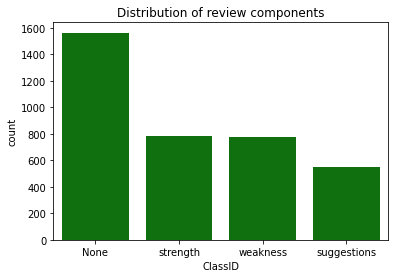

In [16]:
import matplotlib.pyplot as plt
sns.countplot(df.classID, color="g")
plt.xlabel('ClassID')
plt.title('Distribution of review components')

Text(0.5, 1.0, 'Distribution of emotional empathy')

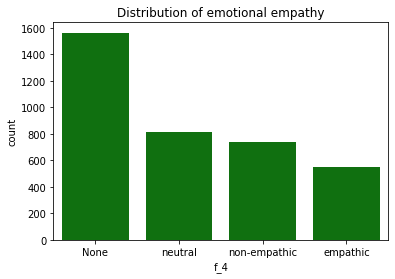

In [18]:
import matplotlib.pyplot as plt
sns.countplot(df.f_4, color="g" )
plt.xlabel('f_4')
plt.title('Distribution of emotional empathy')

Text(0.5, 1.0, 'Distribution of cognitive empathy')

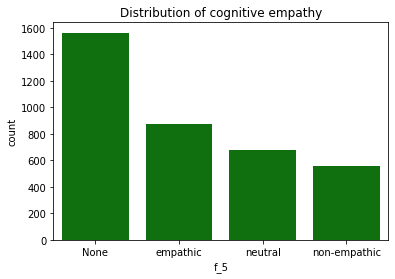

In [17]:
import matplotlib.pyplot as plt
sns.countplot(df.f_5, color="g")
plt.xlabel('f_5')
plt.title('Distribution of cognitive empathy')